### Purpose: This script will train a resne34 CNN to identify a picture of a dessert as one of 5 types: cake, pie, icecream, brownie, or cookie. The output is "export.pkl" which can be used in a web application. 

#### Note: due to the file size of a resnet34 model (>50mb) git-lfs must be used(https://git-lfs.github.com/). If it is not, there will be issues with deployment on binder.

### Note: This notebook was developed on a gradient paperspace P5000 machine. As such the sudo package needed to be installed in order to install git-lfs on this debian linux OS

## Import Required Libraries

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

To download images with Bing Image Search, sign up at Microsoft for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [6]:
key = '897c1fcd05ca410a8386123e59690e69'

In [7]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [8]:
results = search_images_bing(key, 'cake')
ims = results.attrgot('content_url')
len(ims)

150

In [9]:
dessert_types = 'cake','pie','icecream','brownie', 'cookie'
path = Path('desserts')

In [10]:
if not path.exists():
    path.mkdir()
    for o in dessert_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [11]:
fns = get_image_files(path)
fns

(#749) [Path('desserts/cake/00000004.jpg'),Path('desserts/cake/00000003.jpg'),Path('desserts/cake/00000002.jpg'),Path('desserts/cake/00000005.jpg'),Path('desserts/cake/00000000.jpg'),Path('desserts/cake/00000010.jpg'),Path('desserts/cake/00000008.jpg'),Path('desserts/cake/00000011.jpg'),Path('desserts/cake/00000014.jpg'),Path('desserts/cake/00000013.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#7) [Path('desserts/pie/00000000.jpg'),Path('desserts/icecream/00000002.jpg'),Path('desserts/icecream/00000049.jpg'),Path('desserts/icecream/00000092.jpg'),Path('desserts/icecream/00000130.jpg'),Path('desserts/icecream/00000144.jpg'),Path('desserts/cookie/00000054.jpg')]

In [13]:
failed.map(Path.unlink);

## Training the Model, and Using It to Clean Your Data

#### (SECTION A) This is where you come back to when you're finished cleaning your data

In [14]:
desserts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [21]:
desserts = desserts.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = desserts.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.154501,1.088603,0.387755,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.925591,0.533984,0.238095,00:10
1,0.693257,0.376813,0.142857,00:09
2,0.553951,0.367228,0.129252,00:09
3,0.461246,0.364541,0.129252,00:10


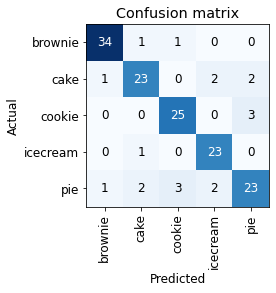

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

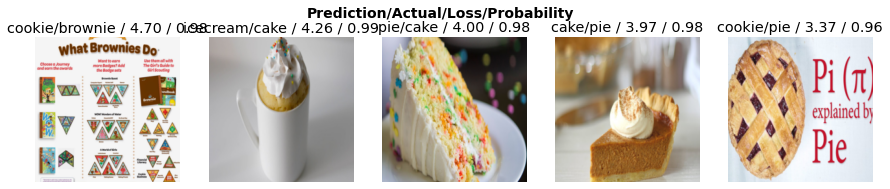

In [26]:
interp.plot_top_losses(5, nrows=1)

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now go back to (SECTION A) and retrain the model

### Export the model for use on an app!

In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]